## Modelling Correlation between Risks
In credit derivative valuation and credit risk management, one of the most important issue is the estimate of default probabilities and their correlations. 

Default correlation measures the tendency of two companies to default at about the same time. For this, generally speaking, there are two ways: using historical default data or using mathematical models, like copulas. 

Historical default data has played an important role in the estimation of default probabilities. However, because default events are rare, there is very limited default data available. Moreover, historical data reflects the historical default pattern only and it may not be a proper indicator of the future. This makes the estimation of default probabilities from historical data difficult and inexact. To use this same data to estimate default correlations is even more difficult and more inexact. 

On the other hand mathematical models don't rely on historical default data. So this is the way that is now used to estimate/apply correlations.

## Gaussian Copula Model

While there are several types of copula function models, the first
introduced was the *one-factor Gaussian copula model*. This model has,
above all, the advantage that can be solved semi-analytically.

Consider a portfolio of $N$ bonds and assume that the marginal
probabilities of default are known for each issuer. Define:

* $t_i$, the time of default of the $i^{th}$ company:
* $Q_i(t)$, the cumulative probability that company $i$ will default before time $t$; that is, the probability that $t_i \le t$.

To generate a one-factor model for the $t_i$ we define random
variables $X_i$ $(1\le i \le N)$

$$X_i = a_i M + \sqrt{1-a_i^2}Z_i,\qquad i = 1, 2,\ldots, N$$

where $M$ and the $Z_i$ are independent zero-mean unit-variance  distributions (hence $X_i$ are also distributed with zero-mean and unit standard-deviation) and $-1 \le a_i \lt 1$.

The previous equation defines a correlation structure between the
$X_i$ which are dependent on a single common factor $M$. The $Z_i$ term is usually 
called the idiosyncratic component of default. 
The correlation between $X_i$ and $X_j$ is

$$\mathrm{Corr}(X_i, X_j) = \cfrac{\mathbb{E}[(X_i-\mu_i)(X_j-\mu_j)]}{\sigma_{X_i}\sigma_{X_j}} =\mathbb{E}[X_i X_j] = a_i a_j \mathbb{E}[M^2] = a_i a_j
$$
where we just exploit the definition of $X_i$ and its properties.

If $F$ is the cumulative distribution function of the $X_i$,
with a percentile to percentile transformation we can map the $X_i$ to the $t_i$, so that $Q_i(t_i) = \mathbb{P}(X_i\le x)=F(x)$.
Therefore the point $X_i = x$ is transformed to $t_i = t$ where
$x = F_i^{-1}[Q_i(t)]$.

Let's note that, *conditional* on $M$, the $N$ default events are independent. So we can write

$$
\begin{split}
Q_i(t_i|M) = \mathbb{P}(X_i\le x|M) &= \mathbb{P}(a_i M + \sqrt{1-a_i^2}Z_i\le x) =\\
&= \mathbb{P}\left(Z_i\le \cfrac{x-a_i M}{\sqrt{1-a_i^2}}\right)
=H_i\left(\cfrac{F^{-1}[Q(t_i)]-a_i M}{\sqrt{1-a_i^2}}\right)
\end{split}
$$
where $H_i$ is the cumulative distribution function of the $Z_i$.

Although in principle any distribution could be used for $M$ and the
$Z$'s (provided they have zero mean and unit variance), one common
choice is to let them be standard normal distributions (resulting in a
Gaussian copula).
So we can specialize the previous equation as

$$
Q_i(t_i|M) = \Phi\left(\cfrac{\Phi^{-1}[Q(t_i)]-a_i M}{\sqrt{1-a_i^2}}\right)
$$
where $\Phi$ denotes the cumulative distribution function of the standard normal distribution.

If we call $\mathcal{C}(t_1,\ldots,t_N)$ the joint distribution of the default times of the $N$ bonds  in the portfolio then

$$
\mathcal{C}(t_1,\ldots,t_N)=\Phi_{A}(\Phi^{-1}(Q_1(t_1)),\ldots,\Phi^{-1}(Q_N(t_N)))
$$
where $A$ is the correlation matrix of the default probabilities, is the one factor Gaussian copula model (one factor because there is only a random variable, $M$, which determines the correlation between $X_i$).

Clearly different choices of distributions result in different copula models, and in different natures of the default dependence. For example, copulas where the \(M\) have heavy tails generate models where there is a
greater likelihood of a clustering of early defaults for several
companies.

### Standard Market Model

Assume the following two assumptions are made:

* all the companies have the same default intensity (hazard rates), i.e, $\lambda_i = \lambda$ (which means they all have the same default probabilities);
* the pairwise default correlations are the same, i.e $a_i = a$; in other words the contribution of the market 	component $M$ is the same for all the companies and the correlation between any two companies is constant, $\rho = a^2$.

Under these assumptions, given the market situation $M = m$, all the
companies have the same cumulative default probability
$DP_{t|m}=Q_i(t_i|m)=\mathbb{P}(X_i \le x|m)$. 
Moreover, for a given value of the
market component $M$, the defaults are mutually independent for all
the underlying companies. 

## Binomial Distribution

In statistics, the binomial distribution is a discrete probability of independent events, where each event has exactly two possible outcomes. For example, if we toss a coin 10 times and we are interested in how many times it will land on heads, the probability of it lending one, two, three, up to 10 head in a row will form a distribution of probabilities or binomial distribution.

The binomial distribution answers to the question which is the probability of exactly k successes on n repeated trials given that:
 
* the number of observations or trials is fixed;
* each observation or trial is independent. Like in the coin toss, the previous toss doesn’t affect the following;
* the probability of success is exactly the same from one trial to another. Each coin toss has 50% chances to fall in heads or tails.

$$\mathrm{PMF_{binomial}} = \binom{n}{k} p^{k}(1-p)^{n-k}$$
where $\binom{n}{k}$ is the binomial coefficient and is equal to $\frac{n!}{k!(n−k)!}$, $p$ is the probability of an outcome.

In [21]:
from scipy.stats import binom

print (binom(10, 0.5).pmf(5))

0.24609375000000025


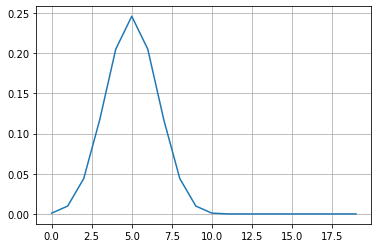

In [23]:
from matplotlib import pyplot as plt

x = range(20)
plt.plot(x, binom(10, 0.5).pmf(x))
plt.grid(True)
plt.show()

In [22]:
b = binom(10, 0.5)
print (b.cdf(10)-b.cdf(4))

0.6230468749999999


Letting $l_{t|m}$ be the total defaults that
have occurred by time $t$ conditional on the market condition
$M = m$, then $l_{t|m}$ follows a binomial distribution and

$$DP(l_{t|m} = j) = \cfrac{N!}{j!(N-j)!}DP^j_{t|m}(1-DP_{t|m})^{N-j},\qquad  j=0, 1, 2,\ldots,N$$

In general to evaluate any function of $g(DP(l_t))$, regardless the parameter $M$ is necessary to average according to the following integral

$$
g(DP(l_{t} = j)) = \int_{-\infty}^{\infty}{g(DP(l_{t|m} = j))\cdot f_M(m)dm}
$$

where $f_M(m)$ is the probability density function (PDF) of the random
variable $M$.

With the assumption that have been made the one factor model is also called *Market Standard Model*.

If the default probabilities are not the same for each company then it is possible through an iterative procedure to determine $DP(l_{t|M}=j)$ and proceed with the integration of the previous equation.

### Extensions of the One Factor Copula Model
Many other one-factor model have been tried: Student t copula, Clayton copula and many others. In general we can define a new model by simply choosing particular functions for $M$ and $Z_i$ provided they are with mean zero and standard deviation 1. 

If instead of the single factor $M$ there are two or more

$$
X_i = a_1 M_1 + a_2 M_2 + \sqrt{1 - a_1^2 - a^2_2}Z_i
$$
and similarly
$$
Q(t|M_1, M_2) = \Phi\left(\cfrac{\Phi^{-1}[Q(t)]-a_1 M_1 - a_2 M_2}{\sqrt{1 - a_1^2 - a^2_2}}\right)
$$

This kind of models are proportionally slower with the increase of the number of factors.
Later we will also see that the correlation can be determined directly from the market quotes.

## Basket Default Swaps
A basket default swap is a credit derivative on a portfolio of reference
entities. The simplest basket default swaps are first-to-default,
second-to-default, or nth-to-default swaps. 

This kind of contracts are very similar to normal CDS except for the protection they offer.
With respect to a basket of reference entities, a first-to-default swap provides insurance for only the first default, a second-to-default swap provides insurance
for only the second default, and a nth-to-default swap provides insurance for only the $n^{th}$ default. 

For example, in the last case, the
seller does not make a payment to the protection buyer for
the first $n-1$ defaulted reference entities, and makes a payment only for the
$n^{th}$ defaulted reference entity. Once there has been this payment the swap terminates.


### Basket CDS Valuation under Market Standard Model
We now present some numerical results for an $n$th-to-default basket. We assume that the
principals and expected recovery rates are the same for all underlying reference assets.
The valuation procedure is similar to that for a regular CDS where there is only one
reference entity.

In a regular CDS indeed its valuation is based on the probability that a default
occured between times $t_1$ and $t_2$. Here instead the valuation will be based on the probability that the
$n^{th}$ default was between times $t_1$ and $t_2$.

We assume the buyer of protection makes quarterly payments at a specified rate
until the $n^{th}$ default occurs or the end of the life of the contract is reached. 

In the event of the $n^{th}$ default occurring, the seller pays $N\cdot(1-R)$. 
The contract can be valued by calculating the expected present value
of payments and the expected present value of payoffs. 

Let's implement now a class that represents a Basket Default Swap. The idea is to reuse the CreditDefaultSwap class that we have already implemented since for example, computing the NPV of a basket can be considered equivalent to compute the NPV of a CDS using the default probabilities derived by the one factor copula model.

### $\tt{args}$ and $\tt{kwargs}$

$\tt{args}$ and $\tt{kwargs}$ represent to useful ways of passing parameters to a function that is called by another function.

In [29]:
a = 1
b = 1
c = 5

def func(x):
    return a*x**2 + b*x + c
    
def runner(f, x):
    return f(x)*2

print (runner(func, 2))

22


If I had to run many times runner changeing each time the values of the parameters $\tt{a}$, $\tt{b}$ and $\tt{c}$ I would be in troubles. So I can use $\tt{args}$ with the star operator.

In [28]:
def func2(x, a, b, c):
    return a*x**2 + b*x + c
    
def runner(f, x, args):
    return f(x, *args)*2

for a in range(3):
    print (runner(func2, 2, args=(a, 1, 5)))

14
22
30


The minimization algorithm is a clear example of this. If you think of $\tt{runner}$ as the $\tt{minimize}$ function and $\tt{func}$ as the objective function the analogy is quite close. In our examples we have always used the first way.

$\tt{kwargs}$ works like $\tt{args}$ except that you have to pass a dictionary with as keys the names of the parameters. Also to expand it you have to use the double-star operator.

In [30]:
def func2(x, a, b, c):
    return a*x**2 + b*x + c
    
def runner(f, x, kwargs):
    return f(x, **kwargs)*2

for v in range(3):
    print (runner(func2, 2, kwargs={"a":v, "c":5, "b":1}))

14
22
30


Going back to the BasketDefaultSwaps class we will use this technique. In fact the idea is:

* compute the default probability of each name according to 

$$Q(t|M) = \Phi\left(\cfrac{\Phi^{-1}[Q(t)]-\sqrt{\rho} M}{\sqrt{1-\rho}}\right)$$;

* compute the jth-to-default probability using the binomial distribution

$$Q(l_{t|m} = j) = \cfrac{N!}{j!(N-j)!}Q(t|M)^j(1-Q(t|M))^{N-j}$$

* create a credit curve with those probabilities;
* re-use the $\tt{CreditDefaultSwap}$ class methods to compute NPV and breakeven rate,through integration of

$$ \mathrm{NPV}(Q(l_{t} = j)) = \int_{-\infty}^{\infty}{\mathrm{NPV}(Q(l_{t|m} = j)) f_M(m)dm} $$
and similarly for the breakeven rate.

In [33]:
from finmarkets_tot import CreditCurve, CreditDefaultSwap, generate_swap_dates
from scipy.stats import norm, binom
from math import sqrt, exp
from scipy.integrate import quad
import numpy as np

class BasketDefaultSwaps:
    def __init__(self, notional,  n_cds, rho, start_date, 
                 spread, maturity, tenor=3, recovery=0.4):
        self.n_cds = n_cds
        self.rho = rho
        self.cds = CreditDefaultSwap(notional, start_date, spread, maturity)
        self.pillar_dates = generate_swap_dates(start_date, maturity*12, tenor)
    
    def one_factor_model(self, M, integrand, Q, dc, ndefaults):
        P = norm.cdf((norm.ppf(Q) - sqrt(self.rho)*M)/(sqrt(1-self.rho)))
        b = binom(self.n_cds, P)
        S = (1-b.cdf(self.n_cds)-b.cdf(ndefaults-1))
        cc = CreditCurve(self.pillar_dates, S)
        return integrand(dc, cc)*norm.pdf(M)
        
    def breakeven(self, dc, ndefaults, Q):
        s = quad(self.one_factor_model, -np.inf, np.inf, 
                 args=(self.cds.breakevenRate, Q, dc, ndefaults))
        return s[0]
    
    def npv(self, dc, ndefaults, Q):
        s = quad(self.one_factor_model, -np.inf, np.inf, 
                 args=(self.cds.npv, Q, dc, ndefaults))
        return s[0]        

Consider first a 5-year 3rd-to-default CDS on a basket of 10 reference entities in the
situation where the copula correlation is 0.3 and the expected recovery rate, $R$, is $40\%$. The term structure of interest rates
is assumed to be flat at 5%. The default probabilities for the 10 entities are generated by
Poisson processes with constant default intensities (hazard rates), $\lambda_i = 0.01$, so that 

$$Q(t) = 1 - e^{-\lambda t} $$

In [4]:
from finmarkets_tot import DiscountCurve, BasketDefaultSwaps
from datetime import date
from dateutil.relativedelta import relativedelta
import numpy as np

n_cds = 10
rho = 0.3
l = 0.01
pillar_dates = []
df = []
observation_date = date.today()

for i in range(6):
    pillar_dates.append(observation_date + relativedelta(years=i))
    df.append(1/(1+0.05)**i)
dc = DiscountCurve(observation_date, pillar_dates, df)

Q = [1-np.exp(-(l*t)) for t in range(6)]

ndefaults = 3
basket = BasketDefaultSwaps(1, n_cds, rho, observation_date, 0.01, 5, 12)
print(basket.breakeven(dc, ndefaults, Q))

0.0017750563139599736


## Collateralized Debt Obligation

A Collateralized Debt Obligation (CDO) is a credit derivative where the issuer, typically investment banks, gather risky assets and repackage them into discrete classes (*tranches*) based on the level of credit risk assumed by the investor. These tranches of securities become the final investment product.

Tranches are named to reflect their risk profile: senior, mezzanine and subordinated/equity and are delimited by the attachment ($L$) and detachment points ($U$), which represent the percentages of the total principal defining their boundaries. 

Each of these tranches has a different level of seniority relative to the others in the sense that a senior tranche has coupon
and principal payment priority over a mezzanine tranche, while a mezzanine tranche has
coupon and principal payment priority over an equity tranche. 
Indeed they receive returns using a set of rules known as *waterfall*. Incomes of the portfolio are first used to provide returns to the most senior tranche, then to the next and so on.
So the senior tranches are generally safest because they have the first claim on the collateral, although they'll offer lower coupon rates.

<img src="cdo_structure.png">

It is important to note
that a CDO only redistributes the total risk associated with the underlying pool of assets
to the priority ordered tranches. It neither reduces nor increases the total risk associated
with the pool.

There are various kind of CDOs:

* in a **Cash CDO** the reference portfolio consists of corporate bonds owned by the CDO issuer. To reduce the capital requirements to cover any potential loss,  the portfolio can be converted into a series of tranches and sold to investors. The equity tranche is usually kept by the issuer being the riskier but also the more rewarded.
* in a **Synthetic CDO** the underlying reference portfolio is no longer a physical portfolio of bonds or loans, instead it is a *fictitious* portfolio consisting of a number of names each with an associated notional amount.

### Cash CDO Expected Losses

Consider a Cash CDO with a maturity of 1 year, made of 125 bonds. Each bond pays a coupon of one unit after 1 year and it has not yet defaulted (the recovery rate $R$ is assumed 0). We are interested in the following three tranches: equity ([0, 3] defaults), mezzanine ([4, 6] defaults) and senior ([7, 9] defaults), (note that now tranches are identified through the number of defaults and not percentages of the principal). 

<img src="ex_cdo_1.png">

We also assume that the probability of default within 1 year are identical for each bond ($Q$) and that the correlation between each pair is also identical and equal to $\rho$.

Under these assumptions we are in the position to use the Gaussian Copula Model and the derivation of the expected losses results quite simple.

The probability of having $l$ defaults, conditional to the market parameter $M$ will follow a binomial distribution given by

$$p(l|M) = \binom{N}{l}Q_M^l (1-Q_M)^{N-l}$$

where $N$ is the number of bonds in the portfolio and 

$$Q_M = \Phi\left(\cfrac{\Phi^{-1}(Q)-\sqrt{\rho}M}{\sqrt{1-\rho}}\right)$$
where $\Phi$ is the standard normal CDF and $Q$ the probability of default within 1 year of a single name.

From the definition of each tranche with have that the expected losses are

* $\mathbb{E}(\textrm{equity loss})=3\cdot\mathbb{P}(l\ge 3) + \sum_{k=1}^{2}{k\cdot\mathbb{P}(l=k)}$
* $\mathbb{E}(\textrm{mezzanine loss})=3\cdot\mathbb{P}(l\ge 6) + \sum_{k=1}^{2}{k\cdot\mathbb{P}(l=k+3)}$
* $\mathbb{E}(\textrm{senior loss})=3\cdot\mathbb{P}(l\ge 9) + \sum_{k=1}^{2}{k\cdot\mathbb{P}(l=k+6)}$

Each probability $\mathbb{P}$ can be calculated by integrating the above with respect to $M$.

Let's see the corresponding $\tt{python}$ implementation.
First we import the necessary modules and define the needed constants.

In [ ]:
from scipy.stats import binom, norm 
from scipy.integrate import quad 
import numpy as np

N = 125
C=1
R=0
q = 0.02
tranches = [[1,3],[4, 6],[7,9]]

The we define a function $\tt{p}$ which implements the expected losses for each tranche.
The function depends on the parameter $\tt{M}$, and takes as inputs the correlation $\tt{rho}$ and the tranche attach-detach limits.

In [ ]:
def p(M, rho, lims):
    qM = norm.cdf((norm.ppf(q)-np.sqrt(rho)*M)/(np.sqrt(1-rho))) 
    pN = binom(N, qM)
    prob = 3*(pN.cdf(N) - pN.cdf(lims[1]-1))
    for i in range(lims[0], lims[1]):
        index = i-lims[0]+1
        prob += index*pN.pmf(i) 
    return norm.pdf(M)*prob

Finally we loop over a range of possible values for the correlation on each tranche to draw the plot of the expected losses vs the correlation.

In [ ]:
res = [[],[],[]]
for i in range(len(tranches)):
    for rho in np.arange(0, 1.05, 0.05): 
        if rho == 1.0:
            rho = 0.99
        v = quad(p, -np.inf, np.inf, args=(rho, tranches[i])) 
    res[i].append(v[0])

Some considerations can be done from these results. First of all, as expected, the equity tranche is the riskier, producing the highest level of loss. The 
$$
\mathbb{E}(\mathrm{equity})\ge \mathbb{E}(\mathrm{mezzanine}) \ge \mathbb{E}(\mathrm{senior})
$$ 
relation holds only if each tranche has the same notional exposure (in our example 3).

Then we can notice that in the equity tranche losses are decreasing in $\rho$. When the correlation is low indeed the probability to have few defaults is higher than that of many. As the correlation increases, there will be more and more "simultaneous" defaults so also other tranches start to suffer losses. In the extreme case of correlation equal to 1 all the tranches are the same (indeed the expected losses curves join together). 

When considering all the tranches covering the entire number of names, the last tranche (the one with detachment point of 100\%) is always increasing in $\rho$. Again this can be explained with the correlated defaults. 
Also, the total expected losses on the three tranches is independent of $\rho$. This is not an accident but it is due to the fact that every default scenario is now categorized in one of the plotted tranches while before this was not the case.

<img src="losses_vs_rho.png">

## Synthetic CDO Valuation

Imagine a CDO made of $N$ names in the reference portfolio. Each name has a notional amount $F$.
When the $i^{th}$ name defaults, then the portfolio incurs in a loss of $F(1-R)$ (the recovery rate is assumed to be fixed for all entities of the portfolio).

The tranche loss function $TL^{L,U}(l)$ for a given time $t$ is a function of the number of defaults $l$ occurred up to that time and is given by

$$TL_{t}^{L,U}=\mathrm{max}(\mathrm{min}(lF(1-R), U)-L, 0)$$
where $lF(1-R)$ is the total portfolio loss, if it is greater than $U$ then the tranche loss is $U$. Conversely if it is lower than $L$ there is no loss.

So for example suppose $L=3\%$ and $U=7\%$ and suppose also that the portfolio loss is $lF(1-R)=5\%$. Then the tranche loss is 2\% of the total portfolio notional (or 50\% of the tranche notional $=7\%-3\%=4\%$).

When an investor *sells protection* on a tranche she is guaranteeing to reimburse any realized losses on the tranche to the *protection buyer*. To better understand this concept it is useful to think of the protection as an *insurance*. 

In return, the protection seller receives a premium at regular intervals (typically every three months) from the protection buyer.

### Premium Leg
As seen above the premium leg represents the payments that are done periodically by the protection buyer to the protection seller.

These payments are made at the end of each time interval and are proportional to the **remaining notional** in the tranche (this is an important difference with respect to CDS, where the contract ends as soon as a default occurs).

We can then write the NPV of the premium leg as

$$\mathrm{NPV}_{\mathrm{premium}}^{L,U}=S\sum^{n}_{i=1}D(d_i)\cfrac{(d_i - d_{i-1})}{360}\left((U-L)-\mathbb{E}[TL_{d-1}^{L,U}]\right)$$
where $n$ is the number of payment dates, $D(d_i)$ is the discount factor, $S$ is the annualized premium. The expected value represents the expected notional remaining in the tranche at time 
$d_{i-1}$.
Note that for simplicity we are ignoring that the default may take place at any time between each payment date.

### Default Leg
The default leg represents the cash flows paid to the protection buyer upon losses occurring in the considered tranche. 

The NPV of the leg can be expressed as
$$\mathrm{NPV}_{\mathrm{default}}^{L,U}=\sum_{i=1}^{n}D(d_i)\left(\mathbb{E}[TL_{d_i}^{L,U}]-\mathbb{E}[TL_{d_{i-1}}^{L,U}]\right)$$
where the argument in parenthesis is the expected losses between time $d_{i-1}$ up to $d_i$. 

Therefore the key ingredient for the valuation of a CDO is the calculation of $\mathbb{E}[TL_{d_i}^{L,U}]$ which appears in both legs.
Using the Gaussian copula it is relatively easy to compute it. 
Indeed we know that 

$$TL_{t}^{L,U}=\mathrm{max}(\mathrm{min}(lF(1-R), U)-L, 0)$$

where the only random variable is the number of defaults $l$. We also know that 

$$\mathbb{E}[TL_{t}^{L,U}] = \sum_{l=0}^{N}TL_{t}^{L,U}\cdot DP(l_t=j)$$

with 

$$DP(l_t=j)=\int_{-\infty}^{\infty} DP(l_{t|M}=j) \phi(M)dM$$

And has we have already seen this calculation can be carried on without too much effort.
The large popularity of the Gaussian copula just resides in this, it allows to compute very quickly very complicated contracts like CDOs which usually involve a large number of correlated names.

### CDO Fair Value
The *fair value* of a CDO tranche is that value of the premium $S^*$ for which the expected value of the premium leg equals the expected value of the default leg and for what we have seen depends on the expected value of the tranche loss function.

$$ S^* = \cfrac{\mathrm{NPV_{default}}^{L,U}}{\sum^{n}_{i=1}D(d_i)\cfrac{(d_i - d_{i-1})}{360}\left((U-L)-\mathbb{E}[TL_{d-1}^{L,U}]\right)}$$

This equation defines the CDO fair value, but can also be used to calibrate the implied correlation parameter from the market.
This can be obtained by plugging into the equation the market premium value and solve for the correlation parameter $\rho$.

In [5]:
from finmarkets_tot import DiscountCurve, CreditCurve, generate_swap_dates
from scipy.integrate import quad
from scipy.stats import norm, binom
import numpy as np
from numpy import exp, sqrt
from datetime import date
from dateutil.relativedelta import relativedelta

class CollDebtObligation:
    def __init__(self, notional, names, tranches, rho, cc,
                 start_date, spreads,
                 maturity, tenor=3, recovery=0.4):
        self.notional = notional
        self.names = names
        self.tranches = tranches
        self.payment_dates = generate_swap_dates(start_date, maturity * 12, tenor)
        self.spreads = spreads
        self.rho = rho
        self.recovery = recovery
        self.cc = cc

    def expected_tranche_loss(self, d, L, U):
        def func(M, Q, l, L, U):
            P = norm.cdf((norm.ppf(Q) - sqrt(self.rho) * M) / (sqrt(1 - self.rho)))
            b = binom(self.names, P)
            return b.pmf(l) * norm.pdf(M) * max(min(l/self.names * self.notional * (1 - self.recovery), U) - L, 0)

        Q = 1 - self.cc.ndp(d)
        v = 0
        for l in range(self.names+1):
            i = quad(func, -np.inf, np.inf, args=(Q, l, L, U))[0]
            v += i
        return v

    def npv_premium(self, tranche, dc):
        L = self.tranches[tranche][0] * self.notional
        U = self.tranches[tranche][1] * self.notional
        v = 0
        for i in range(1, len(self.payment_dates)):
            ds = self.payment_dates[i - 1]
            de = self.payment_dates[i]
            D = dc.df(de)
            ETL = self.expected_tranche_loss(ds, L, U)
            v += D * (de - ds).days / 360 * max((U - L) - ETL, 0)
        return v * self.spreads[tranche]

    def npv_default(self, tranche, dc):
        U = self.tranches[tranche][1] * self.notional
        L = self.tranches[tranche][0] * self.notional
        v = 0
        for i in range(1, len(self.payment_dates)):
            ds = self.payment_dates[i - 1]
            de = self.payment_dates[i]
            ETL1 = self.expected_tranche_loss(ds, L, U)
            ETL2 = self.expected_tranche_loss(de, L, U)
            v += dc.df(de) * (ETL2 - ETL1)
        return v

    def npv(self, tranche, dc):
        return self.npv_default(tranche, dc) - self.npv_premium(tranche, dc)

    def fair_value(self, tranche, dc):
        num = self.npv_default(tranche, dc)
        den = self.npv_premium(tranche, dc) / self.spreads[tranche]
        return num / den

In [6]:
pillar_dates = []
df = []
observation_date = date.today()

for i in range(2):
    pillar_dates.append(observation_date + relativedelta(years=i))
    df.append(1 / (1 + 0.05) ** i)
dc = DiscountCurve(observation_date, pillar_dates, df)

cc = CreditCurve([observation_date + relativedelta(years=i) for i in range(5)],
                 [1, 0.99, 0.97, 0.95, 0.93])

tranches = [[0.0, 0.03], [0.03, 0.06], [0.06, 0.09], [0.09, 1.0]]
spreads = [0.15, 0.07, 0.03, 0.01]

cdo = CollDebtObligation(1, 125, tranches, 0.2, cc,
                         observation_date, spreads, 1, 12)
for i in range(len(tranches)):
    print ("Tranche {} ({}): {:.5f}".format(i, tranches[i], cdo.fair_value(i, dc)))

Tranche 0 ([0.0, 0.03]): 0.17775
Tranche 1 ([0.03, 0.06]): 0.01570
Tranche 2 ([0.06, 0.09]): 0.00288
Tranche 3 ([0.09, 1.0]): 0.00003
